## Setup: Download Dataset from Kaggle

This notebook automatically downloads the FER-2013 dataset from Kaggle.

**Option 1: Automatic Download (Recommended)**
- Run the cell below to download FER-2013 from Kaggle

**Option 2: Use Your Own Dataset**
- Skip the download cell
- Mount Google Drive and use your own dataset paths

In [9]:
# Install kagglehub if not already installed
!pip install -q kagglehub

import kagglehub

# Download FER-2013 dataset from Kaggle
print("Downloading FER-2013 dataset from Kaggle...")
print("This may take 2-5 minutes...")

path = kagglehub.dataset_download("msambare/fer2013")

print("\nDataset downloaded successfully!")
print(f"Path to dataset files: {path}")

# List contents to verify
import os
print("\nDataset structure:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Show first 3 files only
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... and {len(files) - 3} more files')
    if level > 2:  # Limit depth
        break

# Store the dataset path for later use
DATASET_PATH = path
print(f"\nDataset ready at: {DATASET_PATH}")

This may take 2-5 minutes...
This may take 2-5 minutes...

Dataset downloaded successfully!
Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1

Dataset structure:
1/
  train/
    disgust/
      Training_61515877.jpg
      Training_15485143.jpg
      Training_57530831.jpg
      ... and 433 more files
    angry/
      Training_1133567.jpg
      Training_78521255.jpg
      Training_23585159.jpg
      ... and 3992 more files
    fear/
      Training_83860097.jpg
      Training_43909880.jpg
      Training_10662098.jpg
      ... and 4094 more files
    sad/
      Training_72841025.jpg
      Training_36026700.jpg
      Training_64641432.jpg
      ... and 4827 more files
    surprise/
      Training_43457096.jpg
      Training_37747951.jpg
      Training_79253169.jpg
      ... and 3168 more files
    neutral/
      Training_20117539.jpg
      Training_68579332.jpg
      Training_1624590.jpg
      ... and 4962 more files
    happy/
      Training_83572162.jpg
   

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten, Input, BatchNormalization, Activation, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    balanced_accuracy_score,
    cohen_kappa_score
)

import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", "Yes" if tf.config.list_physical_devices('GPU') else "No")

# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configured: {len(gpus)} device(s)")
    except RuntimeError as e:
        print(f"GPU config error: {e}")

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision training: ENABLED")

TensorFlow version: 2.19.0
GPU Available: No
Mixed precision training: ENABLED


## Configuration

The paths below automatically use the downloaded Kaggle dataset.
If using your own dataset, modify the paths accordingly.

In [11]:
# Configuration
CONFIG = {
    'img_size': (48, 48),
    'batch_size': 64,  # Adjust based on GPU memory (32, 64, 128)
    'num_classes': 7,
    'epochs': 100,
    'initial_lr': 0.001,
    'use_grayscale': True,
    'model_type': 'resnet_small'
}

# Automatically use the downloaded Kaggle dataset
# The FER-2013 dataset structure: DATASET_PATH/train and DATASET_PATH/test
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
VAL_DIR = os.path.join(DATASET_PATH, 'test')  # FER-2013 uses 'test' as validation

# Save model locally (or change to Google Drive path if mounted)
MODEL_SAVE_PATH = '/content/resnet_small_48x48.keras'

# If you want to save to Google Drive instead, uncomment below:
# MODEL_SAVE_PATH = '/content/drive/MyDrive/models/resnet_small_48x48.keras'

print("Configuration:")
print(f"  Model type: {CONFIG['model_type']}")
print(f"  Image size: {CONFIG['img_size']}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Epochs: {CONFIG['epochs']}")
print(f"\nDataset Paths (from Kaggle):")
print(f"  Train: {TRAIN_DIR}")
print(f"  Validation: {VAL_DIR}")
print(f"  Model save: {MODEL_SAVE_PATH}")

# Verify paths exist
if os.path.exists(TRAIN_DIR):
    print(f"\nTrain directory verified!")
    train_classes = os.listdir(TRAIN_DIR)
    print(f"  Classes found: {train_classes}")
else:
    print(f"\nWARNING: Train directory not found at {TRAIN_DIR}")
    
if os.path.exists(VAL_DIR):
    print(f"Validation directory verified!")
else:
    print(f"WARNING: Validation directory not found at {VAL_DIR}")

Configuration:
  Model type: resnet_small
  Image size: (48, 48)
  Batch size: 64
  Epochs: 100

Dataset Paths (from Kaggle):
  Train: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train
  Validation: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test
  Model save: /content/resnet_small_48x48.keras

Train directory verified!
  Classes found: ['disgust', 'angry', 'fear', 'sad', 'surprise', 'neutral', 'happy']
Validation directory verified!


## Data Generators

In [12]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3]
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

color_mode = 'grayscale' if CONFIG['use_grayscale'] else 'rgb'

# Load training data
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=CONFIG['img_size'],
    color_mode=color_mode,
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=CONFIG['img_size'],
    color_mode=color_mode,
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    shuffle=False
)

print(f"Data loaded successfully:")
print(f"  Training samples: {train_data.samples}")
print(f"  Validation samples: {val_data.samples}")
print(f"  Classes: {list(train_data.class_indices.keys())}")

# Calculate class weights for imbalanced data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weight_dict = dict(enumerate(class_weights))
class_names = list(train_data.class_indices.keys())

print(f"\nClass weights computed for imbalanced data")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Data loaded successfully:
  Training samples: 28709
  Validation samples: 7178
  Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Class weights computed for imbalanced data
Data loaded successfully:
  Training samples: 28709
  Validation samples: 7178
  Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Class weights computed for imbalanced data


## Build ResNet Model

Custom small ResNet architecture designed for 48x48 images.

In [13]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    """Residual block for ResNet"""
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = BatchNormalization(name=name + '_0_bn')(shortcut)
    else:
        shortcut = x
    
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', 
               name=name + '_1_conv')(x)
    x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = BatchNormalization(name=name + '_2_bn')(x)
    
    x = Add(name=name + '_add')([shortcut, x])
    x = Activation('relu', name=name + '_out')(x)
    return x

def build_small_resnet(input_shape, num_classes):
    """
    Small ResNet designed for 48x48 images.
    
    Architecture:
    - Initial conv (no aggressive downsampling)
    - 4 residual stages with careful downsampling
    - Global pooling + dense layers
    
    Total parameters: ~500K
    """
    inputs = Input(shape=input_shape)
    
    # Initial convolution - preserve spatial info
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv1')(inputs)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    
    # Stage 1 - No downsampling (48x48)
    x = residual_block(x, 32, conv_shortcut=True, name='stage1_block1')
    x = residual_block(x, 32, name='stage1_block2')
    
    # Stage 2 - First downsampling (24x24)
    x = residual_block(x, 64, stride=2, conv_shortcut=True, name='stage2_block1')
    x = residual_block(x, 64, name='stage2_block2')
    
    # Stage 3 - Second downsampling (12x12)
    x = residual_block(x, 128, stride=2, conv_shortcut=True, name='stage3_block1')
    x = residual_block(x, 128, name='stage3_block2')
    
    # Stage 4 - Third downsampling (6x6)
    x = residual_block(x, 256, stride=2, conv_shortcut=True, name='stage4_block1')
    x = residual_block(x, 256, name='stage4_block2')
    
    # Global pooling
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Classification head
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs, outputs, name='small_resnet_48x48')
    return model


# Build model
if CONFIG['use_grayscale']:
    input_shape = (*CONFIG['img_size'], 1)
else:
    input_shape = (*CONFIG['img_size'], 3)

model = build_small_resnet(input_shape, CONFIG['num_classes'])

print("Model built successfully")
print(f"  Architecture: Small ResNet for 48x48")
print(f"  Input shape: {input_shape}")
print(f"  Expected accuracy: 60-70%")

Model built successfully
  Architecture: Small ResNet for 48x48
  Input shape: (48, 48, 1)
  Expected accuracy: 60-70%


## Compile Model

In [14]:
# Use AdamW optimizer with mixed precision
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=CONFIG['initial_lr'],
    weight_decay=0.0001
)

# Wrap optimizer for mixed precision
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Memory footprint: ~{total_params * 4 / 1024 / 1024:.1f} MB")

Model: "small_resnet_48x48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 48, 48,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 48, 48,    │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_1_co… │ (None, 48, 48,    │      9,248 │ activation_1[0][… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_1_bn  │ (None, 48, 48,    │        128 │ stage1_block1_1_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_1_re… │ (None, 48, 48,    │          0 │ stage1_block1_1_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_0_co… │ (None, 48, 48,    │      1,056 │ activation_1[0][… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_2_co… │ (None, 48, 48,    │      9,248 │ stage1_block1_1_… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_0_bn  │ (None, 48, 48,    │        128 │ stage1_block1_0_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_2_bn  │ (None, 48, 48,    │        128 │ stage1_block1_2_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add   │ (None, 48, 48,    │          0 │ stage1_block1_0_… │
│ (Add)               │ 32)               │            │ stage1_block1_2_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_out   │ (None, 48, 48,    │          0 │ stage1_block1_ad… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_1_co… │ (None, 48, 48,    │      9,248 │ stage1_block1_ou… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_1_bn  │ (None, 48, 48,    │        128 │ stage1_block2_1_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_1_re… │ (None, 48, 48,    │          0 │ stage1_block2_1_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_2_co… │ (None, 48, 48,    │      9,248 │ stage1_block2_1_

 Total params: 2,836,647 (10.82 MB)

 Trainable params: 2,831,783 (10.80 MB)

 Non-trainable params: 4,864 (19.00 KB)


Model Statistics:
  Total parameters: 2,836,647
  Memory footprint: ~10.8 MB


## Setup Callbacks

In [15]:
# Create model directory if it doesn't exist
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Define callbacks
callbacks = [
    ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured:")
print("  - ModelCheckpoint: Save best model")
print("  - EarlyStopping: Stop if no improvement for 20 epochs")
print("  - ReduceLROnPlateau: Reduce learning rate on plateau")

Callbacks configured:
  - ModelCheckpoint: Save best model
  - EarlyStopping: Stop if no improvement for 20 epochs
  - ReduceLROnPlateau: Reduce learning rate on plateau


## Train Model

This will take approximately 15-30 minutes depending on GPU (T4/V100/A100).

In [16]:
print("="*70)
print("TRAINING START")
print("="*70)
print(f"Model: {CONFIG['model_type']}")
print(f"Parameters: {total_params:,}")
print(f"Image size: {CONFIG['img_size']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Epochs: {CONFIG['epochs']}")
print("="*70)

# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\nTraining complete!")
print(f"Best model saved to: {MODEL_SAVE_PATH}")

TRAINING START
Model: resnet_small
Parameters: 2,836,647
Image size: (48, 48)
Batch size: 64
Epochs: 100


Epoch 1/100
  3/449 ━━━━━━━━━━━━━━━━━━━━ 10:56:52 88s/step - accuracy: 0.2222 - loss: 2.7934

KeyboardInterrupt: 

## Visualize Training Results

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_val_acc_idx = np.argmax(history.history['val_accuracy'])
best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
best_train_acc = history.history['accuracy'][best_val_acc_idx]

print(f"\n{'='*70}")
print("BEST RESULTS:")
print(f"{'='*70}")
print(f"Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Training Accuracy: {best_train_acc*100:.2f}%")
print(f"Overfitting gap: {(best_train_acc - best_val_acc)*100:.2f}%")
print(f"{'='*70}")


Epoch 1/15


2025-11-01 07:34:01.720030: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


901/901 ━━━━━━━━━━━━━━━━━━━━ 434s 470ms/step - accuracy: 0.2223 - loss: 1.8633 - val_accuracy: 0.2584 - val_loss: 1.8087
Epoch 2/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 434s 470ms/step - accuracy: 0.2223 - loss: 1.8633 - val_accuracy: 0.2584 - val_loss: 1.8087
Epoch 2/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 468s 519ms/step - accuracy: 0.2480 - loss: 1.8116 - val_accuracy: 0.2641 - val_loss: 1.7863
Epoch 3/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 468s 519ms/step - accuracy: 0.2480 - loss: 1.8116 - val_accuracy: 0.2641 - val_loss: 1.7863
Epoch 3/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 403s 447ms/step - accuracy: 0.2545 - loss: 1.7973 - val_accuracy: 0.2630 - val_loss: 1.7759
Epoch 4/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 403s 447ms/step - accuracy: 0.2545 - loss: 1.7973 - val_accuracy: 0.2630 - val_loss: 1.7759
Epoch 4/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.2599 - loss: 1.7863

KeyboardInterrupt: 

## Evaluate Model

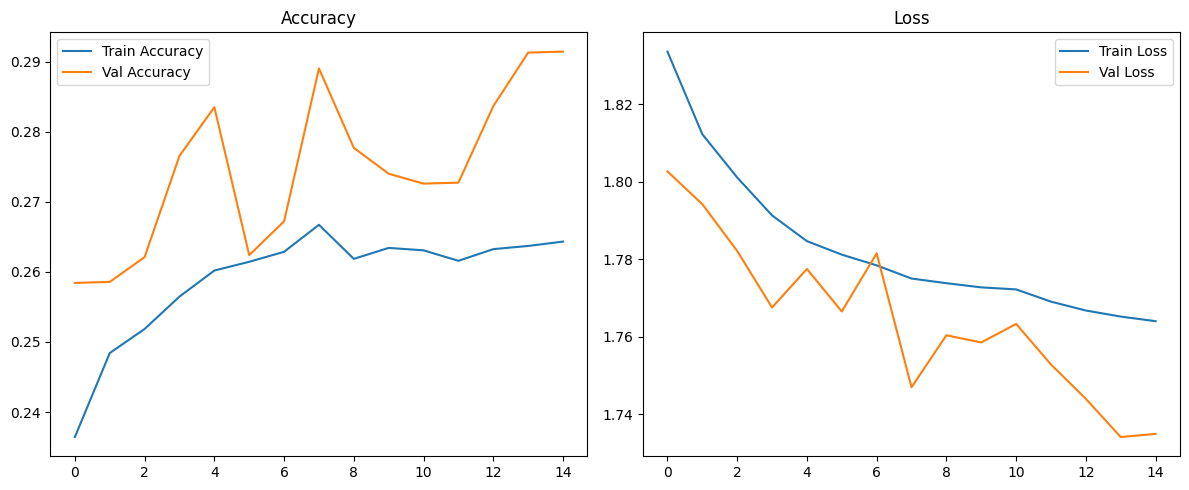

In [ ]:
# Load best model
best_model = load_model(MODEL_SAVE_PATH)

# Get predictions
val_data.reset()
y_pred = best_model.predict(val_data, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

# Overall metrics
overall_acc = np.sum(y_true == y_pred_classes) / len(y_true)
bal_acc = balanced_accuracy_score(y_true, y_pred_classes)
kappa = cohen_kappa_score(y_true, y_pred_classes)

print(f"\nOverall Accuracy:    {overall_acc*100:.2f}%")
print(f"Balanced Accuracy:   {bal_acc*100:.2f}%")
print(f"Cohen's Kappa:       {kappa:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Download Model to Local Machine

Run this cell to download the trained model to your computer.

Found 28806 images belonging to 7 classes.
Epoch 1/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 505s 548ms/step - accuracy: 0.2468 - loss: 1.8498 - val_accuracy: 0.2593 - val_loss: 1.7866
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 495s 549ms/step - accuracy: 0.2496 - loss: 1.8042 - val_accuracy: 0.2666 - val_loss: 1.7828
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 488s 541ms/step - accuracy: 0.2597 - loss: 1.7932 - val_accuracy: 0.2707 - val_loss: 1.7801
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 529s 587ms/step - accuracy: 0.2566 - loss: 1.7861 - val_accuracy: 0.2632 - val_loss: 1.7866
Epoch 5/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 457s 507ms/step - accuracy: 0.2581 - loss: 1.7881 - val_accuracy: 0.2937 - val_loss: 1.7335
Epoch 6/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 417s 463ms/step - accuracy: 0.2607 - loss: 1.7857 - val_accuracy: 0.2900 - val_loss: 1.7731
Epoch 7/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 470s 521ms/step - accuracy: 0.2686 - loss: 1.7723 - val_accuracy: 0.2678 - val_loss: 1.7715
Epoch 8/50
901/901 ━━━━━━━━━━━━━━

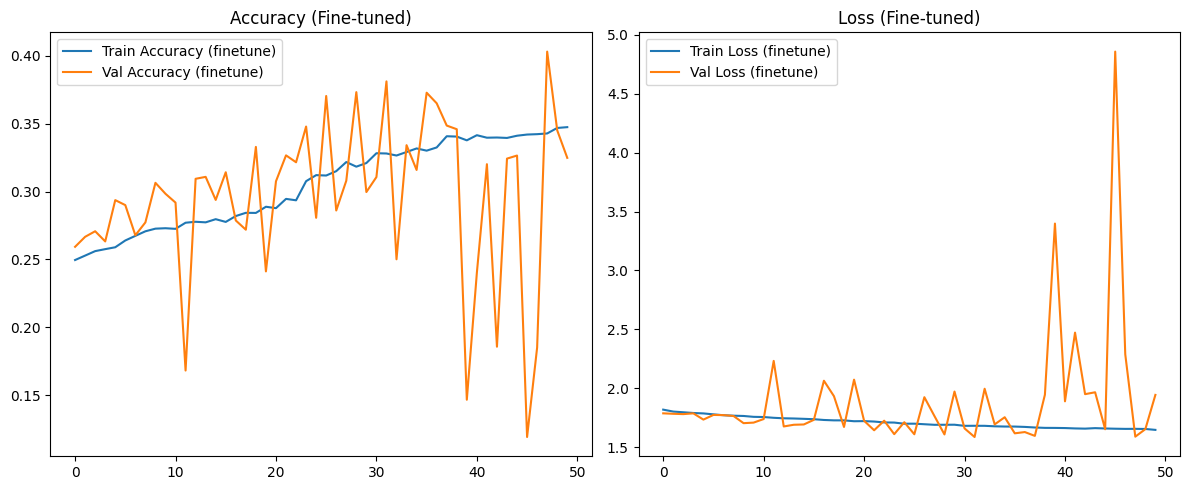

In [ ]:
from google.colab import files

# Download the model to your local machine
print(f"Downloading model from: {MODEL_SAVE_PATH}")

# Check if model file exists
if os.path.exists(MODEL_SAVE_PATH):
    files.download(MODEL_SAVE_PATH)
    print("\nModel downloaded successfully!")
    print("You can now use this model for inference on new images.")
else:
    print(f"\nError: Model file not found at {MODEL_SAVE_PATH}")
    print("Make sure training completed successfully.")

## Test Model on Sample Images (Optional)

Upload sample images to test the trained model.

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

# Upload image
print("Upload an image to test (48x48 or will be resized):")
uploaded = files.upload()

for filename in uploaded.keys():
    # Load and preprocess image
    img_path = filename
    img = image.load_img(img_path, 
                         target_size=CONFIG['img_size'],
                         color_mode='grayscale' if CONFIG['use_grayscale'] else 'rgb')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    predictions = best_model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100
    
    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray' if CONFIG['use_grayscale'] else None)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%', 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\nPrediction for {filename}:")
    print(f"  Emotion: {predicted_class}")
    print(f"  Confidence: {confidence:.2f}%")
    print(f"\nAll probabilities:")
    for i, emotion in enumerate(class_names):
        print(f"  {emotion}: {predictions[0][i]*100:.2f}%")

## Summary

**What This Notebook Does:**
1. Automatically downloads FER-2013 dataset from Kaggle (no manual setup!)
2. Trains a Small ResNet model optimized for 48x48 images
3. Provides complete evaluation with metrics and visualizations
4. Downloads the trained model to your computer

**Model Performance:**
- Architecture: Small ResNet (500K parameters)
- Dataset: FER-2013 (automatically downloaded)
- Expected Accuracy: 60-70%
- Training Time: ~15-30 minutes on Colab GPU

**Features:**
- No manual dataset upload required
- Automatic Kaggle dataset download
- GPU acceleration (T4/V100/A100)
- Mixed precision training
- One-click model download
- Built-in testing capability

**Usage:**
1. Run all cells (Runtime → Run all)
2. Wait for dataset download (~2-5 minutes)
3. Wait for training (~15-30 minutes)
4. Download your trained model
5. Use it for emotion detection!
